In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os

figure_path = os.path.join(os.getcwd(), "report", "figures")
data_path = os.path.join(os.getcwd(), "data")

In [30]:
# arr = np.array([[1,2,3], [4,5,6], [7,8,9]])
# arr[:,0]

# calib_data = np.genfromtxt(os.path.join(data_path, "calibration_moessbauer.csv"), delimiter=",", skip_header=1)
# calib_data.shape

### Calibration of the single channel analyzer
we first plot the measurement of the Fe-57 spectrum that we performed for the calibration.
- We compare between the count and the LLD, which controls the lower limit in which the counts should be observed, i.e. the 

In [31]:
calib_data = np.genfromtxt(os.path.join(data_path, "calibration_moessbauer.csv"), delimiter=",", skip_header=1)
# LLD, count, time, ULD (Delta E = 100%)
lld_data, count_data = calib_data[:,0], calib_data[:,1]

# the time and uld value were the same for each measurement,
# so just take the value from first index
duration, uld_val = calib_data[0,2], calib_data[0,3]

# take error in counts to be purely statistical
counts_err = np.sqrt(count_data)

# print(count_data)

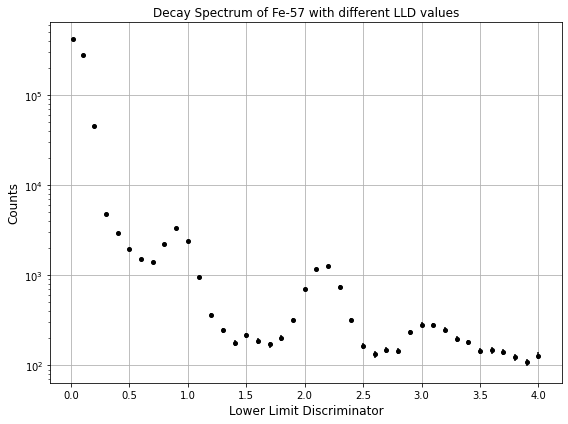

In [32]:
# plot the LLD vs count
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.errorbar(lld_data, count_data, yerr=counts_err, marker="o", color="k", ls="", ms=4.0)
ax.set_xlabel("Lower Limit Discriminator", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Decay Spectrum of Fe-57 with different LLD values")
ax.set_yscale("log")
ax.grid()


# to say something about it, compare to the figure 4.14 in the textbook reference
# that way we can identify this as the 14.4 keV Moessbauer line
# not sure what else to do here, so moving on for now
plt.savefig(os.path.join(figure_path, "calib_plot.png"), dpi=300)

### Looking at hyperfine structure of Moessbauer line (14.4keV transition)
- plot the results
- perform curve fit (from eq)

In [33]:
# get data for LR and RL respectively
moess_lr_data = np.genfromtxt(os.path.join(data_path, "velocity_LR_moessbauer.csv"), delimiter=",", skip_header=1)
moess_rl_data = np.genfromtxt(os.path.join(data_path, "velocity_RL_moessbauer.csv"), delimiter=",", skip_header=1)

# modify time to be counts per second
moess_lr_data[:,3] *= 1e-3
moess_rl_data[:,3] *= 1e-3

time_err = 0.003  # in seconds

# travel distance
L = 25.1e-3   # m
L_err = 0.1e-3  # m

# structure: velocity, motor speed (for reference), counts, time, number of turns
# the velocity is calculated from time and number of turns
# we plot count rate so we need velocity, counts and time

# vel_lr_arr, counts_lr_arr = moess_lr_data[:,0], moess_lr_data[:,2]
# vel_rl_arr, counts_rl_arr = moess_rl_data[:,0], moess_rl_data[:,2]

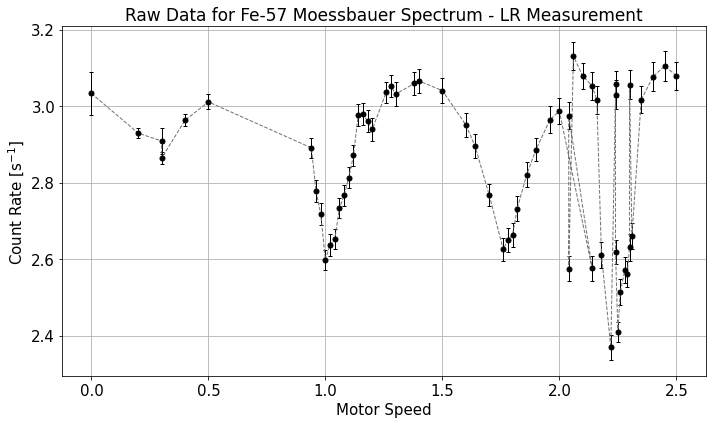

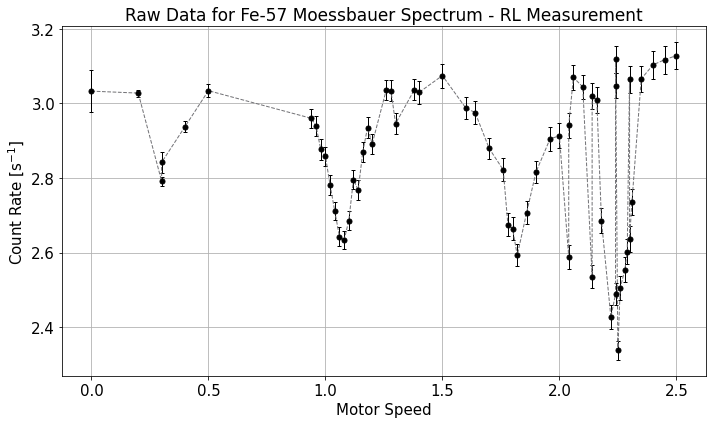

In [34]:
# plot our results (to check)
moess_raw_datas = [moess_lr_data, moess_rl_data]
labels = ["LR", "RL"]


for i, moess_raw_data in enumerate(moess_raw_datas):

    # rewrite things in variable form so that its more clear
    vel, motor_speed, counts, time, nturns, count_rate = (moess_raw_data[:,i] for i in range(6))

    # perform error analysis here
    # error for count rate N / T
    count_rate_err = count_rate * np.sqrt( (np.sqrt(counts) / counts)**2. + (time_err / time)**2.)


    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
    ax.errorbar(motor_speed, count_rate, yerr=count_rate_err, marker="o", ls="--", lw=1.0, 
                ms=5.0, color="#737377", ecolor="k", mfc="k", mec="k", capsize=2.0)
    ax.set_xlabel("Motor Speed", fontsize=15)
    ax.set_ylabel("Count Rate [s$^{{-1}}]$", fontsize=15)
    ax.set_title("Raw Data for Fe-57 Moessbauer Spectrum - {0} Measurement".format(labels[i]), fontsize=17)

    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.grid()

    plt.savefig(os.path.join(figure_path, "raw_moess_{0}.png".format(labels[i])), dpi=300)


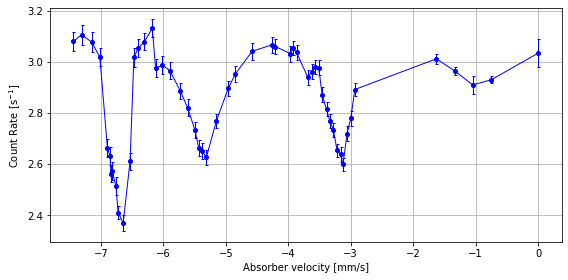

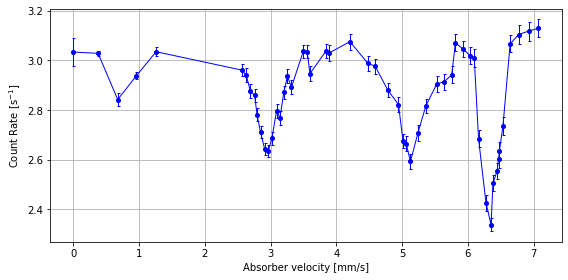

In [35]:
# remove the outliers
# looking at the numbers from apple, we have to remove:
# 7, 14, 15, 22, 24, 58, for lr
# 4, 39, 43, 49, 50, 55,  for rl
# all indices we count from 2 (contrary to python), so we need to shift index by 2

lr_outliers_idces = np.array([7, 13, 14, 15, 22, 24, 58]) - 2
rl_outliers_idces = np.array([4, 39, 43, 48, 49, 50, 55]) - 2

outliers_idces = [lr_outliers_idces, rl_outliers_idces]

moess_datas_filt = []

# perform error analysis here
time_err = 0.003   # uncertantity in time measurement

for i, moess_raw_data in enumerate(moess_raw_datas):
    moess_data_filt = np.delete(moess_raw_data, outliers_idces[i], axis=0)

    # rewrite things in variable form so that its more clear
    vel, motor_speed, counts, time, nturns, count_rate = (moess_data_filt[:,i] for i in range(6))

    # count rate error
    counts_err = np.sqrt(counts)
    count_rate_err = count_rate * np.sqrt( (counts_err / counts)**2. + (time_err / time)**2.)

    # velocity error
    vel_err = np.sqrt( (L_err / L)**2. + (time_err / time)**2.)
    # print(vel_err)

    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.errorbar(vel, count_rate, xerr=vel_err, yerr=count_rate_err, marker="o", ls="-", lw=1.0, ms=4.0, color="b", capsize=1.5)
    ax.set_xlabel("Absorber velocity [mm/s]")
    ax.set_ylabel("Count Rate [s$^{{-1}}$]")
    ax.grid()

    moess_data_new = np.zeros((len(vel), 8))
    moess_data_new[:,:6] = moess_data_filt
    moess_data_new[:,-1] = count_rate_err
    moess_data_new[:,-2] = vel_err

    # append filtered data for future use
    moess_datas_filt.append(moess_data_new)

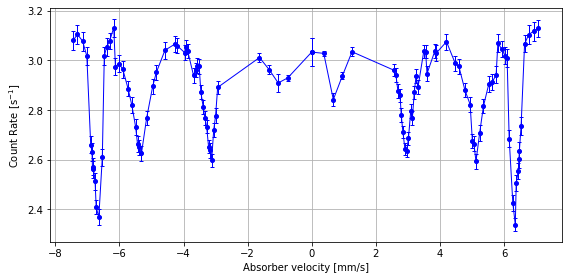

In [36]:
# combine the data
moess_data_comb = np.concatenate(moess_datas_filt, axis=0)

vel, motor_speed, counts, time, nturns, count_rate, vel_err, count_rate_err = (moess_data_comb[:,i] for i in range(8))

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.errorbar(vel, count_rate, yerr=count_rate_err, xerr=vel_err, marker="o", ls="-", lw=1.0, ms=4.0, color="b", capsize=2.0)
ax.set_xlabel("Absorber velocity [mm/s]")
ax.set_ylabel("Count Rate [s$^{{-1}}$]")
ax.grid()


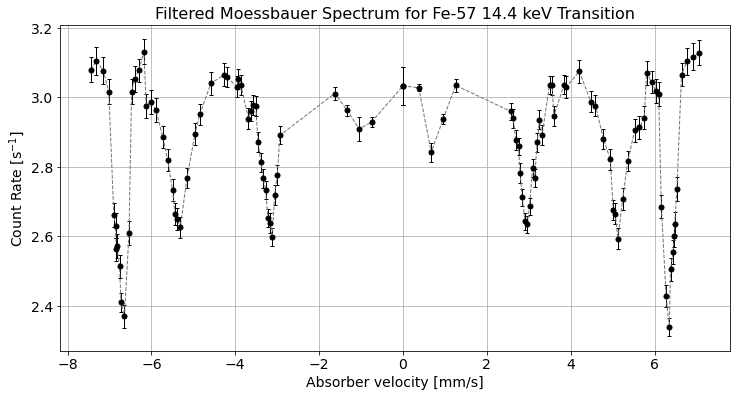

In [37]:
# combine the data
moess_data_comb = np.concatenate(moess_datas_filt, axis=0)

vel, motor_speed, counts, time, nturns, count_rate, vel_err, count_rate_err = (moess_data_comb[:,i] for i in range(8))

fig, ax = plt.subplots(figsize=(12,6))
# fig = plt.figure(figsize=(8,4))
# ax = plt.axes()
ax.errorbar(vel, count_rate, yerr=count_rate_err, xerr=vel_err, marker="o", ls="--", lw=1.0, 
            ms=5.0, color="#737377", ecolor="k", mfc="k", mec="k", capsize=2.0)
ax.set_xlabel("Absorber velocity [mm/s]", fontsize=14)
ax.set_ylabel("Count Rate [s$^{{-1}}$]", fontsize=14)
ax.set_title("Filtered Moessbauer Spectrum for Fe-57 14.4 keV Transition", fontsize=16)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.savefig(os.path.join(figure_path, "moess_spect_filt.png"), dpi=300)


# fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
# ax.errorbar(vel, count_rate, yerr=count_rate_err, xerr=vel_err, marker="o", ls="", lw=1.0, ms=5.0, color="k", capsize=2.0)
# ax.plot(vel_fit, init, label="Initial Fit", color="orange", zorder=3, ls="--")
# ax.legend(prop={"size":12})
# ax.set_xlabel("Absorber velocity [mm/s]", fontsize=14)
# ax.set_ylabel("Count Rate [s$^{{-1}}$]", fontsize=14)
# ax.set_title("Moessbauer Spectrum for Fe-57 14.4 keV Transition", fontsize=16)
# ax.grid()

# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.tick_params(axis='both', which='minor', labelsize=14)

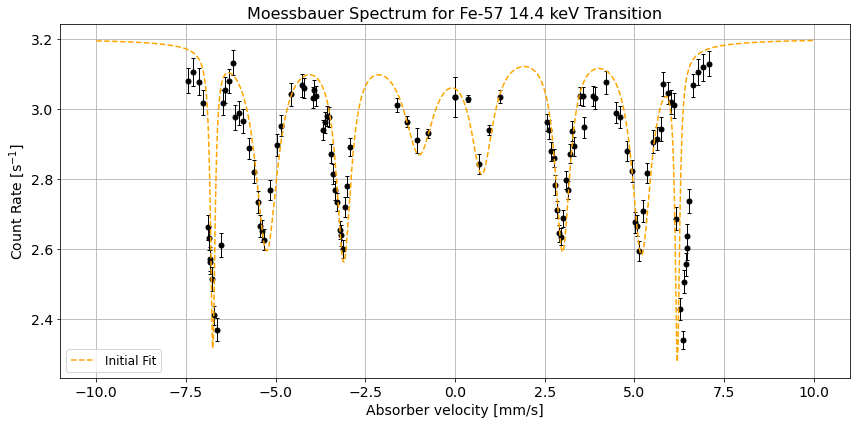

In [38]:
# perform fitting
# we try to use lmfit instead

from lmfit import Model

def lorentzian(v, v0, I0, Gamma_v):
    '''Single Lorentzian function: 
    A - amplitude, x0 - center of peak, gamma /2 - width of peak'''
    # print(type(A), type(gamma), type(x0))
    return -I0 * (Gamma_v / 2)**2. / ((Gamma_v / 2)**2. + (v - v0)**2.)

def offset(v, delta):
    '''Wrapper function for creating offset'''
    return delta


vel, motor_speed, counts, time, nturns, count_rate, vel_err, count_rate_err = (moess_data_comb[:,i] for i in range(8))

# initial guesses
offset_guess = 3.2 # list so that combining parameters is easier

# from left to right
# need to shift amplitude by offset_guess since thats what the actual value should be
lorentz_guess = [
    (-6.75, offset_guess - 2.35, 0.15), (-5.25, offset_guess - 2.61, 0.75), (-3.1, offset_guess - 2.6, 0.5), (-1., offset_guess - 2.9, 1.),
    (0.75, offset_guess - 2.85, 0.75), (3., offset_guess - 2.62, 0.5), (5.2, offset_guess - 2.6, 0.65), (6.2, offset_guess - 2.34, 0.15)
]


# create Model object
# lor = Model(lorentzian)
# print(lor)

# convolve by summing up each lorentzian for each peak we have
Npeaks = 8

multi_lor = Model(lorentzian, prefix="l0_")

# make the parameters
pars = multi_lor.make_params()

# update parameters
pars["l0_v0"].set(lorentz_guess[0][0])
pars["l0_I0"].set(lorentz_guess[0][1])
pars["l0_Gamma_v"].set(lorentz_guess[0][2])

for i in range(Npeaks-1):
    m = Model(lorentzian, prefix='l{0}_'.format(i+1))

    # update parameters for each lorentzian peak
    pars.update(m.make_params())
    pars["l{0}_v0".format(i+1)].set(lorentz_guess[i+1][0])
    pars["l{0}_I0".format(i+1)].set(lorentz_guess[i+1][1])
    pars["l{0}_Gamma_v".format(i+1)].set(lorentz_guess[i+1][2])

    multi_lor += m


# add the offset function
oset = Model(offset)
pars.update(oset.make_params())
pars["delta"].set(offset_guess)

multi_lor += oset

# plot initial guess function
vel_fit = np.linspace(-10, 10, 1000)
init = multi_lor.eval(pars, v=vel_fit)
# print(init)

# plot
fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
ax.errorbar(vel, count_rate, yerr=count_rate_err, xerr=vel_err, marker="o", ls="", lw=1.0, ms=5.0, color="k", capsize=2.0)
ax.plot(vel_fit, init, label="Initial Fit", color="orange", zorder=3, ls="--")
ax.legend(prop={"size":12})
ax.set_xlabel("Absorber velocity [mm/s]", fontsize=14)
ax.set_ylabel("Count Rate [s$^{{-1}}$]", fontsize=14)
ax.set_title("Moessbauer Spectrum for Fe-57 14.4 keV Transition", fontsize=16)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# plt.savefig(os.path.join(figure_path, "moess_spect_init.png"), dpi=300)

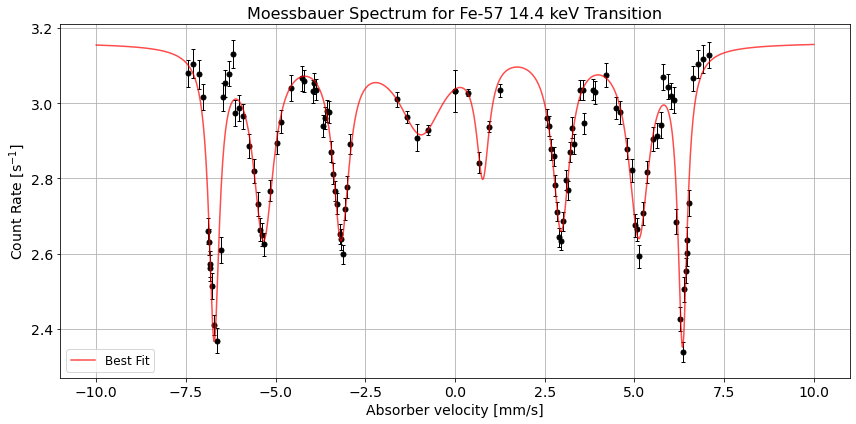

In [39]:
# function for plotting the best fit values
# somehow lmfit doesnt allow plotting best fit with smoother x-values
def multi_lorentzian(v, params, Npeaks=8):
    '''
    Combination of Lorentzian functions.
    params contain dictionary of each parameter
    '''
    offset = params["delta"]
    lor_params = []

    for i in range(Npeaks):
        prefix = "l{0}_".format(i)
        lor_param = params[prefix+"v0"], params[prefix+"I0"], params[prefix+"Gamma_v"]
        lor_params.append(lor_param)

    # sum over 0th axis since we sum over each lorentzian, not over x-values
    return offset + np.sum([lorentzian(v, *lor_param) for lor_param in lor_params], axis=0)

# perform fit
out = multi_lor.fit(count_rate, pars, v=vel, weights=1./count_rate_err)

# evaluate best fit from obtained parameters
params_dict = out.best_values
vel_fit = np.linspace(-10, 10, 1000)
best_fit = multi_lorentzian(vel_fit, params_dict)

# plot
fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
ax.errorbar(vel, count_rate, yerr=count_rate_err, xerr=vel_err, marker="o", ls="", lw=1.0, ms=5.0, color="k", capsize=2.0)
ax.plot(vel_fit, best_fit, label="Best Fit", color="r", zorder=3, alpha=0.7)
ax.legend(prop={"size":12})
ax.set_xlabel("Absorber velocity [mm/s]", fontsize=14)
ax.set_ylabel("Count Rate [s$^{{-1}}$]", fontsize=14)
ax.set_title("Moessbauer Spectrum for Fe-57 14.4 keV Transition", fontsize=16)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# plt.savefig(os.path.join(figure_path, "moess_spect.png"), dpi=300)


In [40]:
# export parameters and their errors as csv file
import csv


bestfit_params = np.zeros((Npeaks, 8))
bestfit_energy_params = np.zeros((Npeaks, 4))

c = 3e8
E0 = 14.4e3 # in eV

def Egamma(v):
    return E0 * v / c 

# headers = "v0 \n v0_err \n I0 \n I0_err \n Gamma_v \n Gamma_v_err \n I0p \n I0p_err"

delta = out.params["delta"].value
delta_err = out.params["delta"].stderr
print("delta: ", delta, "+-", delta_err)

for key in out.params:
    if "delta" in key:
        pass
        
        # print(key, "=", out.params[key].value, "+/-", out.params[key].stderr)
    else:
        # print(key.split("_")[0][1])
        idx = int(key.split("_")[0][1])   # "l{idx}_"
        # check what value is key, index we append vary based on this
        if "v0" in key:
            bestfit_params[idx,0] = out.params[key].value
            bestfit_params[idx,1] = out.params[key].stderr

            bestfit_energy_params[idx,0] = Egamma(out.params[key].value * 1e-3) # convert to m/s
            bestfit_energy_params[idx,1] = Egamma(out.params[key].stderr * 1e-3) # convert to m/s
        elif "I0" in key:
            bestfit_params[idx,2] = out.params[key].value
            bestfit_params[idx,3] = out.params[key].stderr

            new_ampl = delta - out.params[key].value
            new_ampl_err = np.sqrt(delta_err**2. + out.params[key].stderr**2.)

            bestfit_params[idx,6] = new_ampl
            bestfit_params[idx,7] = new_ampl_err

        elif "Gamma_v" in key:
            bestfit_params[idx,4] = out.params[key].value
            bestfit_params[idx,5] = out.params[key].stderr

            bestfit_energy_params[idx,2] = Egamma(out.params[key].value * 1e-3) # convert to m/s
            bestfit_energy_params[idx,3] = Egamma(out.params[key].stderr * 1e-3) # convert to m/s

    
    # bestfit_energy_params[idx,0] = Egamma(out.params[key].value)
    #         bestfit_energy_params[idx,1] = Egamma(out.params[key].stderr)bestfit_energy_params[idx,0] = Egamma(out.params[key].value)
    # bestfit_energy_params[idx,1] = Egamma(out.params[key].stderr)
        # print(key, "=", out.params[key].value, "+/-", out.params[key].stderr)

    # prefix = "l{0}_".format(i)
    # new_ampl = delta - params_dict[prefix + "I0"]
    # new_ampl_err = np.sqrt(delta_err**2. + I0_err[i]**2.)
    # print(f"New Amplitude Error for peak {i+1}: {new_ampl:.3f} +- {new_ampl_err:.3f}")

bestfit_params_headers = ["v0", "v0_err", "I0", "I0_err", "Gamma_v", "Gamma_V_err", "I1", "I1_err"]
bestfit_energy_params_headers = ["E0", "E0_err", "Gamma", "Gamma_err"]


with open("bestfit_params.csv", "w") as f:
    writer = csv.writer(f,  delimiter=',')
    writer.writerow(bestfit_params_headers)
    for i in range(Npeaks):
        writer.writerow(bestfit_params[i,:])
    # writer.writeheader()
    # writer.writerows(bestfit_params.items())

with open("bestfit_energy_params.csv", "w") as f:
    writer = csv.writer(f,  delimiter=',')
    writer.writerow(bestfit_energy_params_headers)
    for i in range(Npeaks):
        writer.writerow(bestfit_energy_params[i,:])
    # writer.writeheader()
    # writer.writerows(bestfit_params.items())

# np.savetxt("best_fit_params.csv",bestfit_params, fmt="%.5f", delimiter=",")
# np.savetxt("best_fit_energy_params.csv",bestfit_energy_params, fmt="%.5e", delimiter=",")
# print(bestfit_params)

delta:  3.1625923085081245 +- 0.025081452544300952


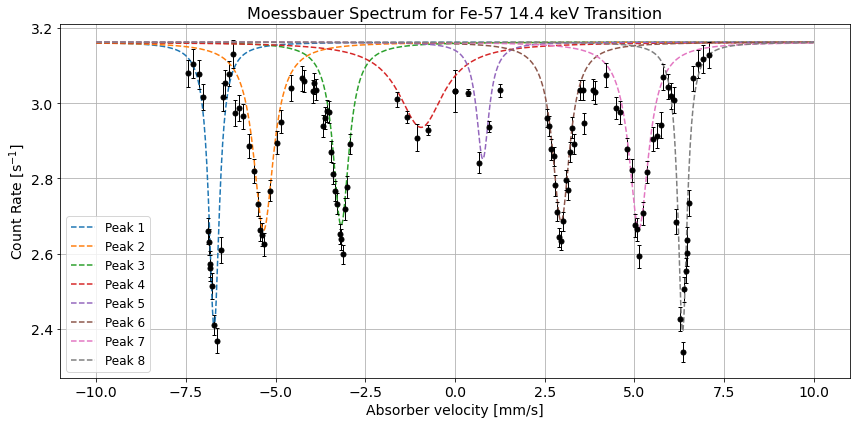

In [41]:
# to plot each Lorentzian peak
comps = out.eval_components(v=vel_fit)
# print(comps)

fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)

for i in range(Npeaks):
    ax.plot(vel_fit, comps["l{0}_".format(i)] + comps["offset"], label="Peak {0}".format(i+1), ls="--")
ax.errorbar(vel, count_rate, yerr=count_rate_err, xerr=vel_err, marker="o", ls="", lw=1.0, ms=5.0, color="k", capsize=2.0)
# ax.plot(vel_fit, best_fit, label="Best Fit", color="r", zorder=3, alpha=0.7)
ax.legend(prop={"size":12})
ax.set_xlabel("Absorber velocity [mm/s]", fontsize=14)
ax.set_ylabel("Count Rate [s$^{{-1}}$]", fontsize=14)
ax.set_title("Moessbauer Spectrum for Fe-57 14.4 keV Transition", fontsize=16)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.savefig(os.path.join(figure_path, "moess_spect_comps.png"), dpi=300)


In [42]:
# determine the isomer shift
# take the difference between equivalent peaks
E0_arr = bestfit_energy_params[:,0]


for i in range(3):
    peak_diff = 1

In [43]:
# # print out the best fit parameters and their associated errors
# # print(out.fit_report())

# params_dict = out.best_values

# # somehow lmfit doesnt have a way to extract the parameter errors easily
# # only way is to copy paste from the fit report...
# I0_err = bestfit_params[:,3]

# # get the amplitude as shown in the plot
# delta = params_dict["delta"]
# delta_err = 0.02047550

# for i in range(Npeaks):
#     prefix = "l{0}_".format(i)
#     new_ampl = delta - params_dict[prefix + "I0"]
#     new_ampl_err = np.sqrt(delta_err**2. + I0_err[i]**2.)
#     print(f"New Amplitude Error for peak {i+1}: {new_ampl:.3f} +- {new_ampl_err:.3f}")
    



In [44]:
# # found this code online for multi-lorentzian fit
# # not sure how to fit for our data because still not used to
# # the numpy notations you are using

# from scipy.optimize import leastsq

# def lorentzian( x, x0, a, gam ):
#     return a * gam**2 / ( gam**2 + ( x - x0 )**2)

# def multi_lorentz( x, params ):
#     off = params[0]
#     paramsRest = params[1:]
#     assert not ( len( paramsRest ) % 3 )
#     return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

# def res_multi_lorentz( params, xData, yData ):
#     diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
#     return diff

# xData, yData = np.loadtxt('HEMAT_1.dat', unpack=True )
# yData = yData / max(yData)

# generalWidth = 1

# yDataLoc = yData
# startValues = [ max( yData ) ]
# counter = 0

# while max( yDataLoc ) - min( yDataLoc ) > .1:
#     counter += 1
#     if counter > 20: ### max 20 peak...emergency break to avoid infinite loop
#         break
#     minP = np.argmin( yDataLoc )
#     minY = yData[ minP ]
#     x0 = xData[ minP ]
#     startValues += [ x0, minY - max( yDataLoc ), generalWidth ]
#     popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ) )
#     yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

# print popt
# testData = [ multi_lorentz(x, popt ) for x in xData ]

# fig = plt.figure()
# ax = fig.add_subplot( 1, 1, 1 )
# ax.plot( xData, yData )
# ax.plot( xData, testData )
# plt.show()
